Trying out engression for probabilistic forecasting by stacking it on top of other models (here catboost). 

This notebook only slightly modifies Stéphane Degeye's [winning entry](https://www.kaggle.com/code/stphanedegeye/1st-place-catboost-cqr-21-07-2024-01) in this [competition](https://www.kaggle.com/competitions/probabilistic-forecasting-i-temperature/overview). The modified notebook's submission (using "multi" in the code) scored public: 0.2901 and private: 0.8673.

# Probabilistic forecasting I: Temperature
## Kaggle Competition hosted by Carl McBride Ellis
## Catboost Multiquantiles Regression - Conformalized Quantile Regression

In [ ]:
# import utility_script_crps_score as us
# help(us.crps)

# Others
import pickle
import torch
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

from engression_pytorch import energy_score, gConcat

# the utility script
import _us

# Data Structure
import numpy as np
import pandas as pd

# Model
from catboost import CatBoostRegressor, Pool

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Utils
from sklearn.model_selection import train_test_split

# Error Handling
import warnings
warnings.filterwarnings("ignore")

# Plot
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})

%matplotlib inline

# A. Data Loading

In [2]:
# Load the dataset
train_df = pd.read_csv('data/train_and_Public.csv')
test_df = pd.read_csv('data/test.csv')
submission_df = pd.read_csv('data/sample_submission.csv')

In [3]:
train_df

,id,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature
0,0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
...,...,...,...,...,...,...,...,...,...
67003,67003,2018-05-29 22:45:00,13.329,3.885,8.457,1.954,4.630,1.401,10.130000
67004,67004,2018-05-29 23:00:00,14.468,5.023,9.808,2.630,4.538,1.432,10.130000
67005,67005,2018-05-29 23:15:00,15.539,5.291,10.909,3.056,4.569,1.340,10.271000
67006,67006,2018-05-29 23:30:00,14.066,4.957,9.772,3.020,4.447,1.401,10.271000


In [4]:
test_df

,id,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB
0,64320,2018-05-02 00:00:00,14.133,2.076,9.346,-0.036,4.538,1.279
1,64321,2018-05-02 00:15:00,12.123,1.541,7.818,-0.746,4.538,1.249
2,64322,2018-05-02 00:30:00,12.525,1.741,8.209,-0.284,4.477,1.279
3,64323,2018-05-02 00:45:00,12.324,1.942,7.747,0.249,4.630,1.371
4,64324,2018-05-02 01:00:00,14.602,1.407,9.630,-0.320,4.477,1.310
...,...,...,...,...,...,...,...,...
5355,69675,2018-06-26 18:45:00,9.310,3.550,5.437,1.670,3.868,1.462
5356,69676,2018-06-26 19:00:00,10.114,3.550,6.183,1.564,3.716,1.462
5357,69677,2018-06-26 19:15:00,10.784,3.349,7.000,1.635,3.746,1.432
5358,69678,2018-06-26 19:30:00,11.655,3.617,7.533,1.706,4.173,1.523


# B. Data Preparation

In [5]:
train_df['date'] = pd.to_datetime(train_df['date'])

In [6]:
test_df['date'] = pd.to_datetime(test_df['date'])

# C. Exploratory Data Analysis

## Shape of Dataframe

In [7]:
num_rec_train = train_df.shape[0]
print(f'Train dataframe contains {num_rec_train} records belongings to {round(num_rec_train / 96, 1)} days')

num_rec_test = test_df.shape[0]
print(f'Test dataframe contains {num_rec_test} records belongings to {round(num_rec_test / 96, 1)} days')

Train dataframe contains 67008 records belongings to 698.0 days
Test dataframe contains 5360 records belongings to 55.8 days


## Missing Values

In [8]:
# Detecting missing values in train_df
missing_values = train_df.isnull().sum()

print("Missing values in each column of train_df:")
print(missing_values)

# Detecting missing values in kaggle_test_df
missing_values = test_df.isnull().sum()

print("Missing values in each column of test_df:")
print(missing_values)

Missing values in each column of train_df:
id             0
date           0
feature_AA     0
feature_AB     0
feature_BA     0
feature_BB     0
feature_CA     0
feature_CB     0
Temperature    0
dtype: int64
Missing values in each column of test_df:
id            0
date          0
feature_AA    0
feature_AB    0
feature_BA    0
feature_BB    0
feature_CA    0
feature_CB    0
dtype: int64


## Tabular View

In [9]:
train_df.head()

,id,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature
0,0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001


In [10]:
test_df.head()

,id,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB
0,64320,2018-05-02 00:00:00,14.133,2.076,9.346,-0.036,4.538,1.279
1,64321,2018-05-02 00:15:00,12.123,1.541,7.818,-0.746,4.538,1.249
2,64322,2018-05-02 00:30:00,12.525,1.741,8.209,-0.284,4.477,1.279
3,64323,2018-05-02 00:45:00,12.324,1.942,7.747,0.249,4.630,1.371
4,64324,2018-05-02 01:00:00,14.602,1.407,9.630,-0.320,4.477,1.310


## Data Distribution

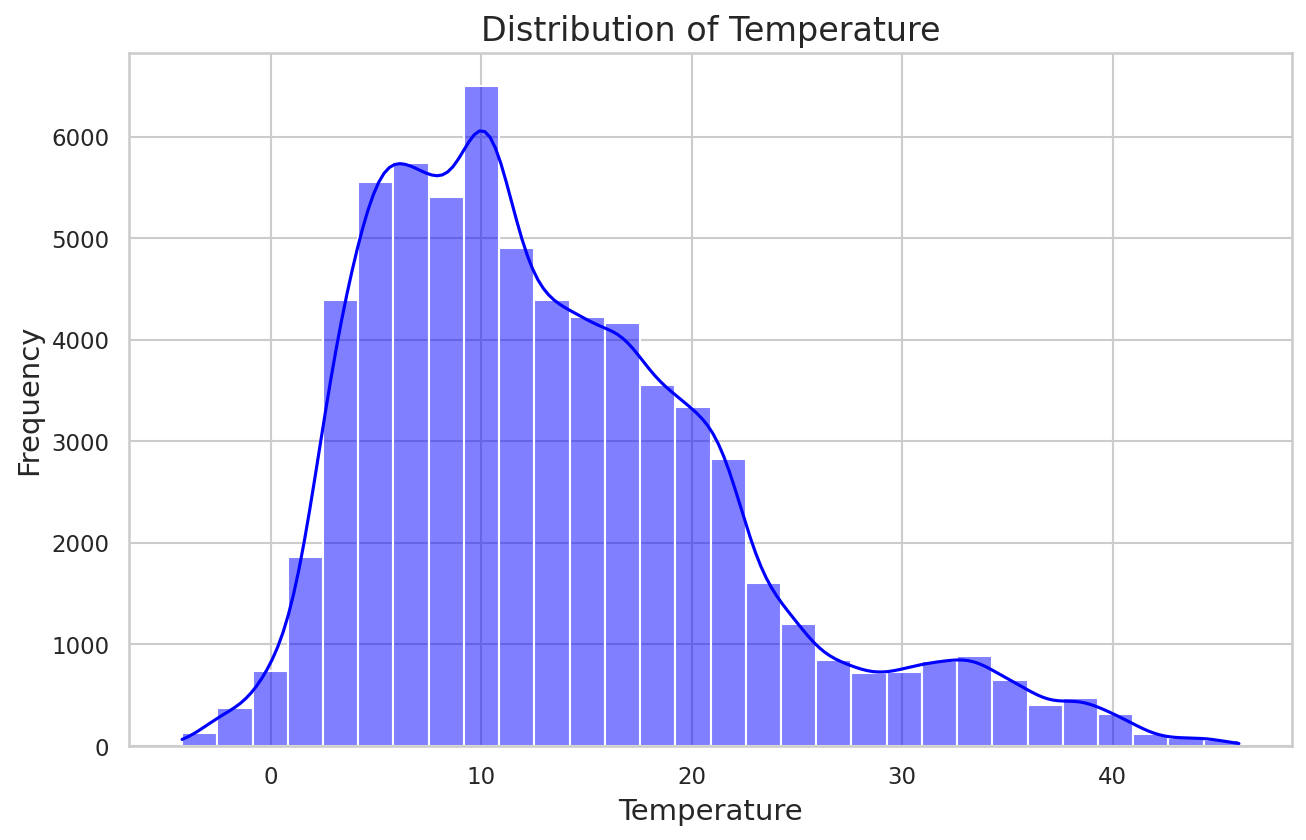

In [11]:
# Set the theme for the plot
sns.set_theme(style="whitegrid")

# Create a histogram of the total bill
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Temperature'], bins=30, kde=True, color='blue')

# Adding titles and labels
plt.title('Distribution of Temperature', fontsize=16)
plt.xlabel('Temperature', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()

## Check Stationarity

In [12]:
ADF_result = adfuller(train_df['Temperature'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -4.103689681383466
p-value: 0.0009550125795118518


<div class="alert alert-block alert-danger">
<b> [Stationarity] </b> p-value < 0.05, so we can reject the Null Hypothesis, Time Series is Stationary!</div>

## Partial Autocorrelation

Text(0.5, 1.0, 'Partial Autocorrelation feature_AA')

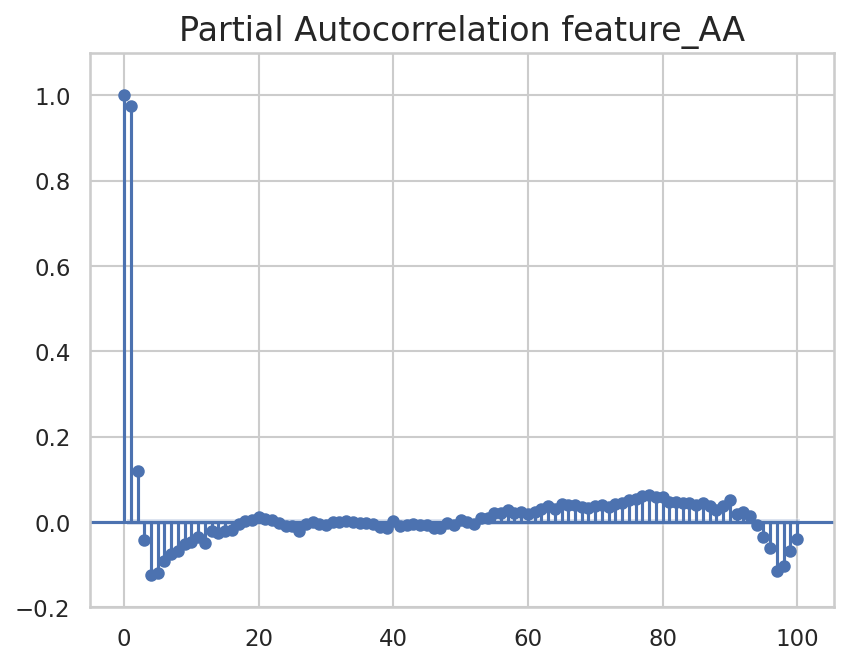

In [13]:
plot_pacf(train_df['feature_AA'], lags=100)
plt.ylim(-0.2, 1.1)
plt.tight_layout

# Adding titles and labels
plt.title('Partial Autocorrelation feature_AA', fontsize=16)

Text(0.5, 1.0, 'Partial Autocorrelation feature_AB')

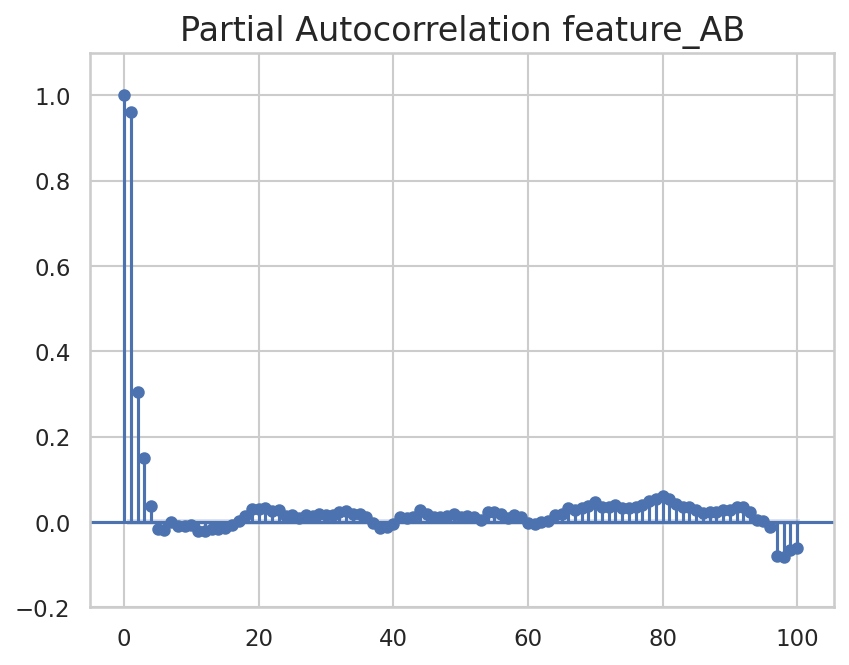

In [14]:
plot_pacf(train_df['feature_AB'], lags=100)
plt.ylim(-0.2, 1.1)
plt.tight_layout

# Adding titles and labels
plt.title('Partial Autocorrelation feature_AB', fontsize=16)

Text(0.5, 1.0, 'Partial Autocorrelation feature_BA')

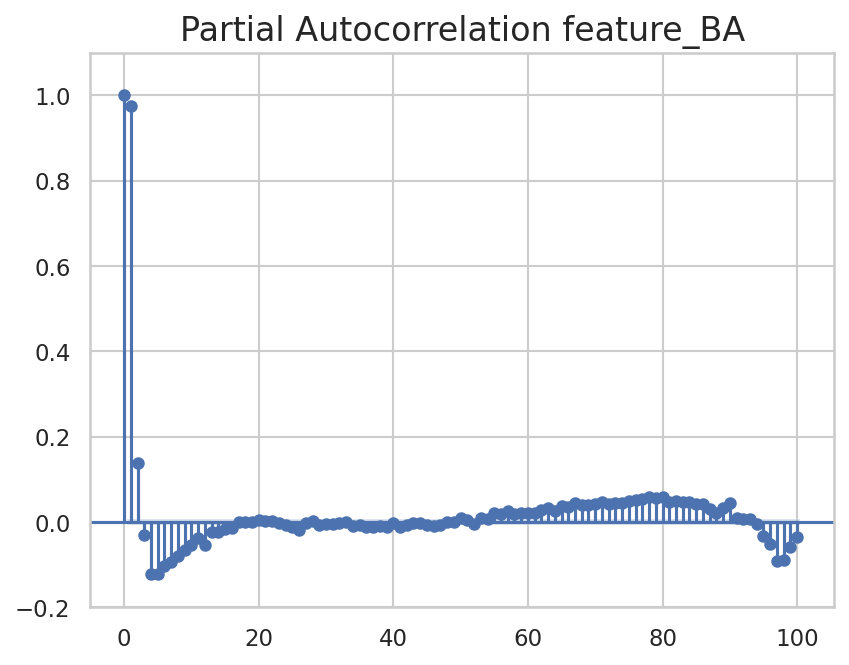

In [15]:
plot_pacf(train_df['feature_BA'], lags=100)
plt.ylim(-0.2, 1.1)
plt.tight_layout

# Adding titles and labels
plt.title('Partial Autocorrelation feature_BA', fontsize=16)

Text(0.5, 1.0, 'Partial Autocorrelation feature_BB')

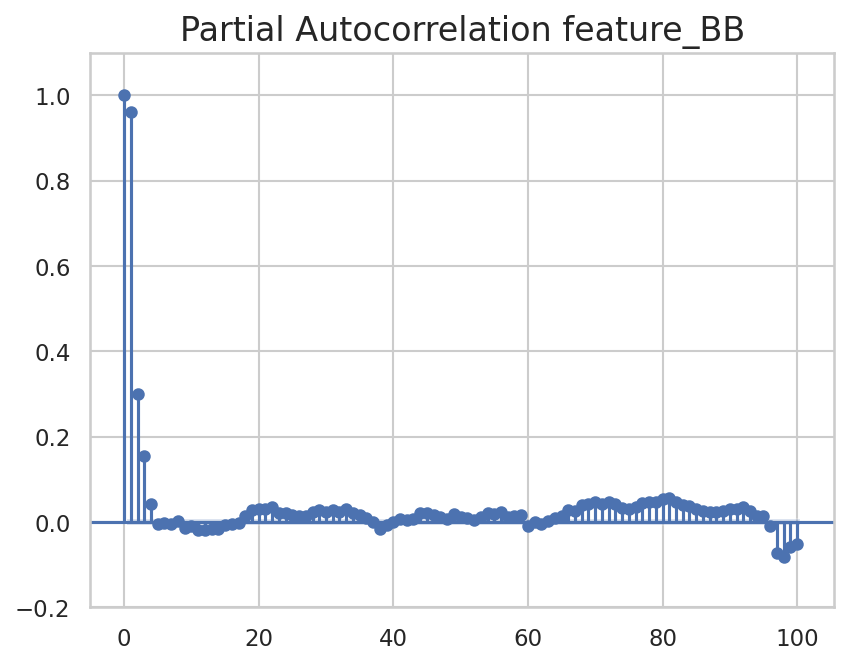

In [16]:
plot_pacf(train_df['feature_BB'], lags=100)
plt.ylim(-0.2, 1.1)
plt.tight_layout

# Adding titles and labels
plt.title('Partial Autocorrelation feature_BB', fontsize=16)

Text(0.5, 1.0, 'Partial Autocorrelation feature_CA')

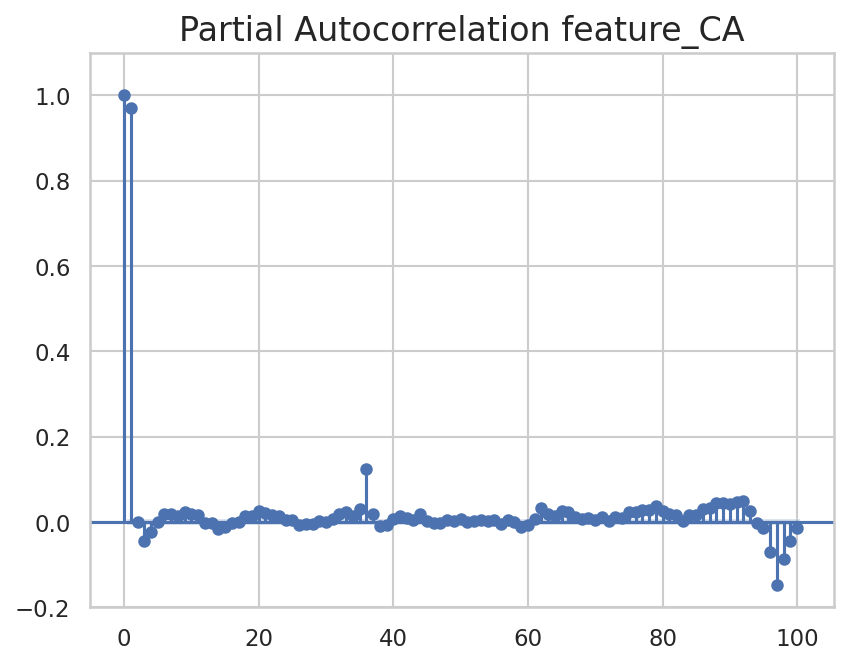

In [17]:
plot_pacf(train_df['feature_CA'], lags=100)
plt.ylim(-0.2, 1.1)
plt.tight_layout

# Adding titles and labels
plt.title('Partial Autocorrelation feature_CA', fontsize=16)

Text(0.5, 1.0, 'Partial Autocorrelation feature_CB')

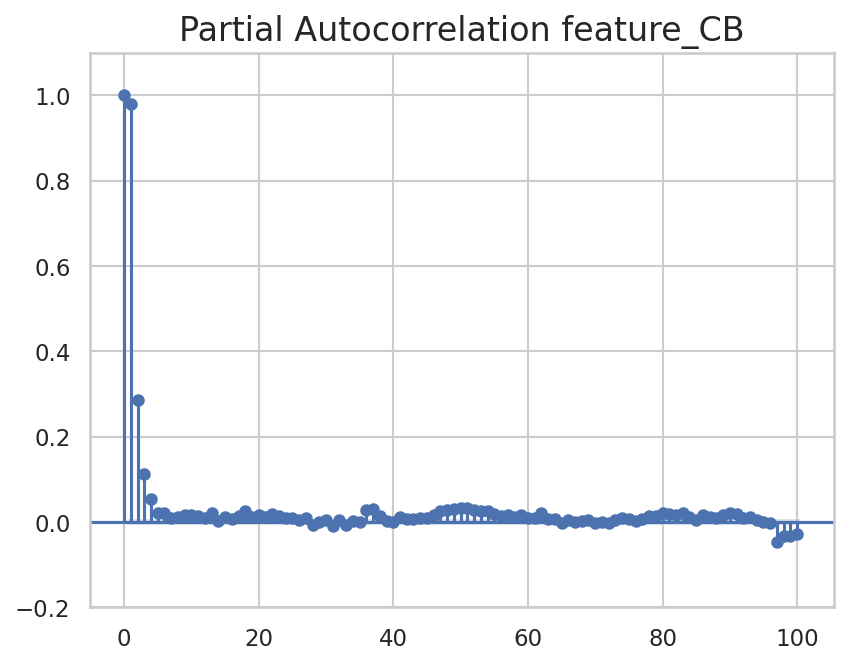

In [18]:
plot_pacf(train_df['feature_CB'], lags=100)
plt.ylim(-0.2, 1.1)
plt.tight_layout

# Adding titles and labels
plt.title('Partial Autocorrelation feature_CB', fontsize=16)

# D. Features Engineering

In [19]:
# Inform model about the temporal progression of the data
train_df['id'] = train_df['id'].astype(float)
test_df['id'] = test_df['id'].astype(float)

# Create Calendar Features
train_df['year'] = train_df['date'].dt.year.astype(int)
train_df['month'] = train_df['date'].dt.month.astype(int)
train_df['day'] = train_df['date'].dt.day.astype(int)
train_df['hour'] = train_df['date'].dt.hour.astype(int)
train_df['week_of_year'] = train_df['date'].apply(lambda x: x.isocalendar()[1])
train_df['day_of_week'] = train_df['date'].dt.dayofweek.astype(int)

test_df['year'] = test_df['date'].dt.year.astype(int)
test_df['month'] = test_df['date'].dt.month.astype(int)
test_df['day'] = test_df['date'].dt.day.astype(int)
test_df['hour'] = test_df['date'].dt.hour.astype(int)
test_df['week_of_year'] = test_df['date'].apply(lambda x: x.isocalendar()[1])
test_df['day_of_week'] = test_df['date'].dt.dayofweek.astype(int)

# Create Lag Features
features_prefix = "feature_"
features_suffix = "_lag_"

lag_features = [
                {'AA' : ['1', '2', '4', '6', '97', '98']},
                {'AB' : ['1', '2', '3', '98']},
                {'CA' : ['1', '36', '97', '98']},
                {'CB' : ['1', '2', '3']}
               ]

for lag_feature in lag_features:
    for lag_list in lag_feature.values():    
        for lag in lag_list:
          train_df[features_prefix + ', '.join(lag_feature.keys()) + features_suffix + lag] = train_df[features_prefix + ', '.join(lag_feature.keys())].shift(int(lag))
          test_df[features_prefix + ', '.join(lag_feature.keys()) + features_suffix + lag] = test_df[features_prefix + ', '.join(lag_feature.keys())].shift(int(lag))

# Create Fourier terms for dayly seasonality
train_fourier_day = np.sin(2 * np.pi * np.arange(len(train_df)) / 96)
train_fourier_day += np.cos(2 * np.pi * np.arange(len(train_df)) / 96)
train_df['fourier_terms_day'] = train_fourier_day

test_fourier_day = np.sin(2 * np.pi * np.arange(len(test_df)) / 96)
test_fourier_day += np.cos(2 * np.pi * np.arange(len(test_df)) / 96)
test_df['fourier_terms_day'] = test_fourier_day

# Create Fourier terms for weekly seasonality
train_fourier_week = np.sin(2 * np.pi * np.arange(len(train_df)) / 96*7)
train_fourier_week += np.cos(2 * np.pi * np.arange(len(train_df)) / 96*7)
train_df['fourier_terms_week'] = train_fourier_week

test_fourier_week = np.sin(2 * np.pi * np.arange(len(test_df)) / 96*7)
test_fourier_week += np.cos(2 * np.pi * np.arange(len(test_df)) / 96*7)
test_df['fourier_terms_week'] = test_fourier_week

# Remove highly correlated features (unnecessarily increase model complexity)
train_df.drop('feature_BA', axis=1, inplace=True)
train_df.drop('feature_BB', axis=1, inplace=True)
train_df.drop('date', axis=1, inplace=True)

test_df.drop('feature_BA', axis=1, inplace=True)
test_df.drop('feature_BB', axis=1, inplace=True)
test_df.drop('date', axis=1, inplace=True)

In [20]:
train_df

,id,feature_AA,feature_AB,feature_CA,feature_CB,Temperature,year,month,day,hour,...,feature_AB_lag_98,feature_CA_lag_1,feature_CA_lag_36,feature_CA_lag_97,feature_CA_lag_98,feature_CB_lag_1,feature_CB_lag_2,feature_CB_lag_3,fourier_terms_day,fourier_terms_week
0,0.0,5.827,2.009,4.203,1.340,30.531000,2016,7,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000
1,1.0,5.760,2.076,4.264,1.401,30.459999,2016,7,1,0,...,NaN,4.203,NaN,NaN,NaN,1.340,NaN,NaN,1.063262,1.339161
2,2.0,5.760,1.942,4.234,1.310,30.038000,2016,7,1,0,...,NaN,4.264,NaN,NaN,NaN,1.401,1.340,NaN,1.121971,1.402115
3,3.0,5.760,1.942,4.234,1.310,27.013000,2016,7,1,0,...,NaN,4.234,NaN,NaN,NaN,1.310,1.401,1.340,1.175876,1.175876
4,4.0,5.693,2.076,4.142,1.371,27.787001,2016,7,1,1,...,NaN,4.234,NaN,NaN,NaN,1.310,1.310,1.401,1.224745,0.707107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67003,67003.0,13.329,3.885,4.630,1.401,10.130000,2018,5,29,22,...,4.287,4.752,2.559,4.569,4.630,1.340,1.432,1.066,0.625491,-1.411186
67004,67004.0,14.468,5.023,4.538,1.432,10.130000,2018,5,29,23,...,4.689,4.630,2.711,4.508,4.569,1.401,1.340,1.432,0.707107,-1.224745
67005,67005.0,15.539,5.291,4.569,1.340,10.271000,2018,5,29,23,...,4.488,4.538,2.680,4.386,4.508,1.432,1.401,1.340,0.785695,-0.785695
67006,67006.0,14.066,4.957,4.447,1.401,10.271000,2018,5,29,23,...,5.224,4.569,2.711,4.325,4.386,1.340,1.432,1.401,0.860919,-0.184592


In [21]:
test_df

,id,feature_AA,feature_AB,feature_CA,feature_CB,year,month,day,hour,week_of_year,...,feature_AB_lag_98,feature_CA_lag_1,feature_CA_lag_36,feature_CA_lag_97,feature_CA_lag_98,feature_CB_lag_1,feature_CB_lag_2,feature_CB_lag_3,fourier_terms_day,fourier_terms_week
0,64320.0,14.133,2.076,4.538,1.279,2018,5,2,0,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000
1,64321.0,12.123,1.541,4.538,1.249,2018,5,2,0,18,...,NaN,4.538,NaN,NaN,NaN,1.279,NaN,NaN,1.063262,1.339161
2,64322.0,12.525,1.741,4.477,1.279,2018,5,2,0,18,...,NaN,4.538,NaN,NaN,NaN,1.249,1.279,NaN,1.121971,1.402115
3,64323.0,12.324,1.942,4.630,1.371,2018,5,2,0,18,...,NaN,4.477,NaN,NaN,NaN,1.279,1.249,1.279,1.175876,1.175876
4,64324.0,14.602,1.407,4.477,1.310,2018,5,2,1,18,...,NaN,4.630,NaN,NaN,NaN,1.371,1.279,1.249,1.224745,0.707107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5355,69675.0,9.310,3.550,3.868,1.462,2018,6,26,18,26,...,3.215,3.746,3.503,3.320,3.290,1.492,1.371,1.432,-0.785695,-0.785695
5356,69676.0,10.114,3.550,3.716,1.462,2018,6,26,19,26,...,3.081,3.868,3.564,3.350,3.320,1.462,1.492,1.371,-0.707107,-1.224745
5357,69677.0,10.784,3.349,3.746,1.432,2018,6,26,19,26,...,2.813,3.716,3.868,3.320,3.350,1.462,1.462,1.492,-0.625491,-1.411186
5358,69678.0,11.655,3.617,4.173,1.523,2018,6,26,19,26,...,2.813,3.746,3.533,3.716,3.320,1.432,1.462,1.462,-0.541196,-1.306563


## Pearson Pairwise Correlation

In [22]:
pear_corr = train_df.drop(['id'], axis=1).corr(method='pearson')
pear_corr.style.background_gradient(cmap='Greens', axis=0)

,feature_AA,feature_AB,feature_CA,feature_CB,Temperature,year,month,day,hour,week_of_year,day_of_week,feature_AA_lag_1,feature_AA_lag_2,feature_AA_lag_4,feature_AA_lag_6,feature_AA_lag_97,feature_AA_lag_98,feature_AB_lag_1,feature_AB_lag_2,feature_AB_lag_3,feature_AB_lag_98,feature_CA_lag_1,feature_CA_lag_36,feature_CA_lag_97,feature_CA_lag_98,feature_CB_lag_1,feature_CB_lag_2,feature_CB_lag_3,fourier_terms_day,fourier_terms_week
feature_AA,1.000000,0.122063,0.294185,0.033516,0.063114,-0.157987,0.044273,0.044876,-0.117455,0.049104,0.002357,0.976227,0.958601,0.913788,0.854096,0.789483,0.779302,0.111644,0.101353,0.092188,0.092336,0.282314,0.098370,0.200050,0.188968,0.027440,0.021572,0.015963,0.505168,0.022900
feature_AB,0.122063,1.000000,0.242555,0.352234,0.251134,-0.135263,0.248843,0.050730,-0.232794,0.246125,0.018866,0.128399,0.135410,0.151034,0.167848,0.110330,0.117282,0.960662,0.946376,0.935381,0.802605,0.237369,0.109820,0.149467,0.146596,0.346969,0.341883,0.336353,0.193589,0.022131
feature_CA,0.294185,0.242555,1.000000,0.323866,0.133640,0.153328,-0.119545,0.106054,0.014994,-0.109129,0.006837,0.294092,0.291186,0.279448,0.263208,0.214635,0.214809,0.238446,0.233669,0.229084,0.167617,0.970908,0.431591,0.579805,0.568457,0.312048,0.301083,0.291087,0.009290,0.051838
feature_CB,0.033516,0.352234,0.323866,1.000000,0.087059,0.076730,-0.050836,0.032741,-0.041703,-0.046628,0.012497,0.035981,0.038892,0.044943,0.050855,-0.000267,0.003629,0.352120,0.352015,0.351303,0.287160,0.312523,0.135050,0.143561,0.142534,0.980636,0.972662,0.965464,-0.037838,0.013183
Temperature,0.063114,0.251134,0.133640,0.087059,1.000000,-0.606526,0.234547,0.003515,0.049383,0.227676,0.015562,0.059311,0.055817,0.049696,0.044955,0.058681,0.055770,0.252928,0.254659,0.256358,0.243037,0.133603,0.145556,0.116721,0.116652,0.087915,0.088646,0.089358,-0.081548,0.003780
year,-0.157987,-0.135263,0.153328,0.076730,-0.606526,1.000000,-0.633153,-0.015855,-0.000000,-0.627706,-0.008256,-0.157975,-0.157961,-0.157940,-0.157911,-0.155126,-0.155109,-0.135295,-0.135321,-0.135352,-0.136792,0.153317,0.153924,0.154499,0.154497,0.076705,0.076688,0.076673,0.000000,0.000000
month,0.044273,0.248843,-0.119545,-0.050836,0.234547,-0.633153,1.000000,0.014153,-0.000000,0.988954,0.013087,0.044252,0.044231,0.044184,0.044129,0.039766,0.039739,0.248856,0.248861,0.248869,0.248002,-0.119576,-0.120778,-0.122298,-0.122321,-0.050849,-0.050865,-0.050878,0.000000,-0.000000
day,0.044876,0.050730,0.106054,0.032741,0.003515,-0.015855,0.014153,1.000000,0.000000,0.087790,-0.008205,0.044885,0.044917,0.044810,0.044643,-0.005620,-0.005632,0.050897,0.051119,0.051286,0.044708,0.106125,0.106379,0.097464,0.097408,0.032846,0.032973,0.033119,0.000000,0.000000
hour,-0.117455,-0.232794,0.014994,-0.041703,0.049383,-0.000000,-0.000000,0.000000,1.000000,-0.000000,-0.000000,-0.141879,-0.166630,-0.209705,-0.247925,-0.141641,-0.166383,-0.246035,-0.258712,-0.269712,-0.258445,0.012537,-0.027012,0.013056,0.009019,-0.040163,-0.038917,-0.039093,-0.569669,-0.095504
week_of_year,0.049104,0.246125,-0.109129,-0.046628,0.227676,-0.627706,0.988954,0.087790,-0.000000,1.000000,0.000906,0.049122,0.049143,0.049167,0.049167,0.042649,0.042625,0.246197,0.246263,0.246331,0.247543,-0.109111,-0.110679,-0.117080,-0.117108,-0.046596,-0.046566,-0.046532,0.000000,-0.000000


# E. Modeling

## Hyperparameters

In [23]:
quantile_mapping = {
    95: ['0.025', '0.975'],
    90: ['0.05', '0.95'],
    80: ['0.10', '0.90'],
    70: ['0.15', '0.85'],
    60: ['0.20', '0.80'],
    50: ['0.25', '0.75'],
    40: ['0.30', '0.70'],
    30: ['0.35', '0.65'],
    20: ['0.40', '0.60'],
    10: ['0.45', '0.55']
}

In [24]:
quantiles = [0.025, 0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,0.975]
levels = np.array([95, 90, 80, 70, 60, 50, 40, 30, 20, 10])

In [25]:
quantile_str = str(quantiles).replace('[','').replace(']','')

In [26]:
submission_val_df = submission_df[:5360].copy()

## Dataset Splitting

In [27]:
X = train_df.drop('Temperature', axis=1)
y = train_df['Temperature']

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=5360)

In [29]:
# X_proper_train, X_cal, y_proper_train, y_cal = train_test_split(X_train, y_train, test_size=0.12, random_state=1)

In [30]:
# train_pool = Pool(data=X_proper_train, label=y_proper_train)
train_pool = Pool(data=X_train, label=y_train)
val_pool = Pool(data=X_val, label=y_val)
# cal_pool = Pool(data=X_cal, label=y_cal)
test_pool = Pool(data=test_df)

## Model Definition and Fitting on Proper Training dataset

In [55]:
# model definition
catboost_model = CatBoostRegressor(
                                       #  loss_function = f'MultiQuantile:alpha={quantile_str}',
                                        loss_function = 'MAE', # MAE
                                        thread_count = -1,
                                        bootstrap_type =  "Bernoulli",
                                        sampling_frequency= 'PerTree',
                                        iterations = 10000,
                                       #  task_type='GPU',
                                     **{'learning_rate': 0.015,
                                          'max_depth': 10,
                                          'subsample': 0.75,
                                          'colsample_bylevel': 0.9,
                                          'min_data_in_leaf': 37},
                                           verbose=1000
                              )


# model fitting on training set
catboost_model.fit(train_pool, eval_set=(val_pool))

0:	learn: 6.6717271	test: 6.6596445	best: 6.6596445 (0)	total: 31.5ms	remaining: 5m 15s
1000:	learn: 0.9734192	test: 1.0242190	best: 1.0242190 (1000)	total: 27.4s	remaining: 4m 5s
2000:	learn: 0.6913310	test: 0.7822016	best: 0.7822016 (2000)	total: 54.6s	remaining: 3m 38s
3000:	learn: 0.5794853	test: 0.7030584	best: 0.7030584 (3000)	total: 1m 21s	remaining: 3m 9s
4000:	learn: 0.5137325	test: 0.6611098	best: 0.6611027 (3999)	total: 1m 48s	remaining: 2m 43s
5000:	learn: 0.4711266	test: 0.6373215	best: 0.6373215 (5000)	total: 2m 14s	remaining: 2m 14s
6000:	learn: 0.4450346	test: 0.6249713	best: 0.6249713 (6000)	total: 2m 41s	remaining: 1m 47s
7000:	learn: 0.4202399	test: 0.6131255	best: 0.6131255 (7000)	total: 3m 7s	remaining: 1m 20s
8000:	learn: 0.4009392	test: 0.6050499	best: 0.6050499 (8000)	total: 3m 33s	remaining: 53.3s
9000:	learn: 0.3826332	test: 0.5974360	best: 0.5974360 (9000)	total: 3m 59s	remaining: 26.5s
9999:	learn: 0.3658590	test: 0.5909143	best: 0.5909029 (9996)	total: 4m 2

In [58]:
torch.save(catboost_model, 'models/catboost_model.p')

In [31]:
# catboost_model = torch.load('models/catboost_model.p', weights_only = False)
catboost_model = torch.load('models/catboost_model_multi.p', weights_only = False)

## Predictions

In [32]:
# predict_cal = multiquantiles_model.predict(cal_pool)
# predict_val = multiquantiles_model.predict(val_pool)
# predict_test = multiquantiles_model.predict(test_pool)

predict_train = catboost_model.predict(train_pool) # to train engression bit
predict_val = catboost_model.predict(val_pool)
predict_test = catboost_model.predict(test_pool)

In [33]:
predict_train.shape

(61648, 21)

# F. Engression

In [34]:
# TODO could add other covariates!
# TODO could tune hyperparameters

# Learn Y | X = x, where X catboost's prediction
X = torch.from_numpy(predict_train).float() # multi
# X = torch.from_numpy(predict_train)[:, None].float()
Y = torch.from_numpy(y_train.to_numpy())[:, None].float()

X_val_ = torch.from_numpy(predict_val).float() # multi
# X_val_ = torch.from_numpy(predict_val)[:, None].float()
y_val_ = torch.from_numpy(y_val.to_numpy())[:, None].float()

# X_test_ = torch.from_numpy(predict_test)[:, None].float()
X_test_ = torch.from_numpy(predict_test).float() # multi

X.shape, Y.shape, X_val_.shape, y_val_.shape, X_test_.shape

(torch.Size([61648, 21]),
 torch.Size([61648, 1]),
 torch.Size([5360, 21]),
 torch.Size([5360, 1]),
 torch.Size([5360, 21]))

In [35]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # Residual MLP block
        h1 = F.gelu(self.fc1(x))
        h2 = F.gelu(self.fc2(h1) + h1)       # Residual 1
        h3 = F.gelu(self.fc3(h2) + h2)       # Residual 2

        return self.out(h3)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        nn.init.zeros_(m.bias)



noise_dim = 128
model = MLP(input_dim = X.shape[1] + noise_dim, hidden_dim = 256)
model.apply(init_weights)

g = gConcat(model = model, m_train = 16, m_eval = 1024, noise_dim = noise_dim)

ds = torch.utils.data.TensorDataset(X, Y)
dl = torch.utils.data.DataLoader(ds, batch_size = 128, shuffle = True)

In [36]:
opt = torch.optim.Adam(g.parameters(), lr = 3e-4)
g.train()
g.to('cuda')

losses = []

for _ in range(3):
    for x, y in dl:
        x, y = x.to('cuda'), y.to('cuda')
        opt.zero_grad()
        preds = g(x)
        loss = energy_score(y, preds, p = 1.0) # NOTE: changed this
        loss.backward()
        opt.step()
        losses.append(loss.item())
        print(loss.item())

23.766799926757812
15.178667068481445
5.366940498352051
1.7474814653396606
6.23493766784668
6.176446914672852
5.618107795715332
2.876206874847412
0.8405896425247192
2.1428518295288086
3.015062093734741
3.686671257019043
3.3160510063171387
1.9800220727920532
0.7861160039901733
1.4831242561340332
2.5619444847106934
2.5544166564941406
2.1028859615325928
0.9672977924346924
1.1856305599212646
1.5704337358474731
2.222400188446045
1.5914256572723389
1.060761570930481
0.8374674320220947
1.1254074573516846
1.5823496580123901
1.3249069452285767
0.8482470512390137
0.7547962665557861
0.926115870475769
1.032020092010498
1.1174172163009644
0.7238973379135132
0.7853161096572876
0.9278277158737183
0.9937844276428223
0.9587738513946533
0.7269842624664307
0.7922388315200806
0.956961989402771
0.8519884347915649
0.7215992212295532
0.7071981430053711
0.788859486579895
0.8062212467193604
0.6626216173171997
0.6744475364685059
0.7313904762268066
0.7992628812789917
0.6815736293792725
0.7123600244522095
0.82392

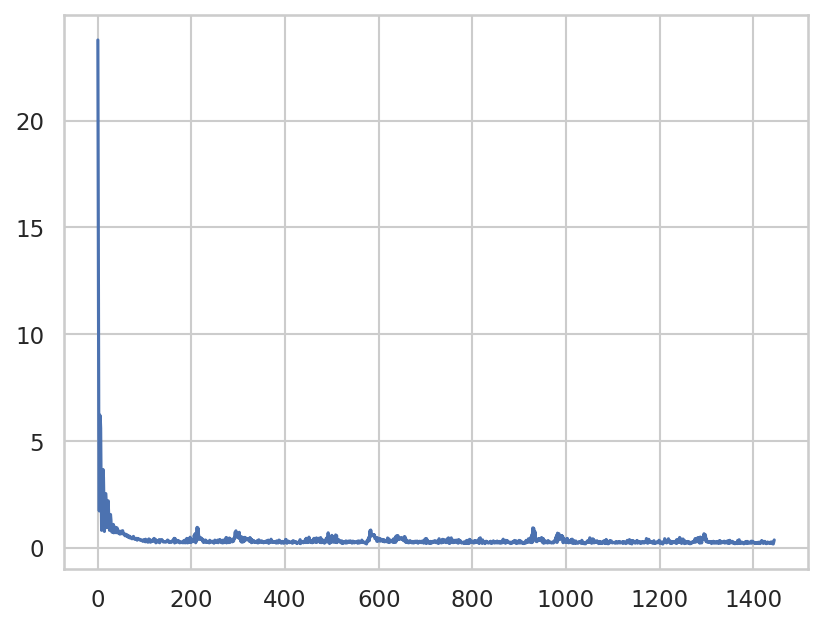

In [37]:
plt.plot(losses)

In [38]:
def pred_adjusted(X,batched):

    with torch.no_grad():

        g.eval()

        if batched:

            # batch preds? didn't use batch norm, so don't think?
            ds = torch.utils.data.TensorDataset(X)
            dl = torch.utils.data.DataLoader(ds, batch_size = 128, shuffle = False)

            y_adjusted = []
            for x, in dl:
                x = x.to('cuda')
                y_adjusted.extend(g(x).cpu().tolist())
            
            y_adjusted = torch.tensor(y_adjusted)

        else:
            y_adjusted = g(X.to('cuda')).cpu()
            
        return torch.quantile(y_adjusted, q = torch.Tensor(quantiles), dim = 1)

In [39]:
# pred_quantiles = torch.quantile(y_adjusted, q = torch.Tensor(quantiles), dim = 1) # (quantile, data point, 1)

for X, df in zip([X_val_, X_test_], [submission_val_df, submission_df]):

    pred_quantiles = pred_adjusted(X, True)
    df.iloc[:, 1:] = pred_quantiles.numpy()[:,:,0].T

In [40]:
submission_val_df

,id,0.025,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,...,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,0.975
0,64320,12.050282,12.264287,12.589404,12.788671,12.878804,12.971922,13.045395,13.115787,13.186324,...,13.387822,13.437257,13.507695,13.575788,13.647488,13.716461,13.815893,13.921036,14.057722,14.210577
1,64321,33.237923,33.426369,33.618744,33.709412,33.799637,33.885559,33.957546,34.014729,34.059155,...,34.218391,34.274452,34.335014,34.399448,34.452843,34.510319,34.580578,34.680855,34.832157,34.915668
2,64322,22.596600,22.700207,22.872751,22.989151,23.058495,23.157917,23.217508,23.267805,23.319670,...,23.489100,23.528088,23.576729,23.631332,23.690485,23.761641,23.835531,23.904074,24.034765,24.150160
3,64323,12.697564,12.834384,13.028636,13.153250,13.232697,13.301239,13.357881,13.428306,13.489108,...,13.635391,13.696609,13.748967,13.808356,13.875803,13.945704,14.010170,14.105173,14.231151,14.351569
4,64324,18.449663,18.631163,18.812284,18.961533,19.043777,19.110435,19.179682,19.244343,19.294966,...,19.458323,19.511547,19.560789,19.614145,19.656788,19.714005,19.795341,19.914766,20.043419,20.165657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5355,69675,8.352065,8.504173,8.753589,8.908206,9.016772,9.123833,9.196452,9.269960,9.314679,...,9.482904,9.542601,9.603099,9.666629,9.732843,9.804113,9.911774,10.044439,10.176463,10.317292
5356,69676,3.383204,3.593653,3.817740,3.982737,4.105522,4.195782,4.296641,4.391073,4.491394,...,4.719196,4.800360,4.879342,4.961023,5.036939,5.145395,5.258236,5.413623,5.623202,5.826220
5357,69677,11.185077,11.342660,11.516884,11.632239,11.713600,11.779386,11.857141,11.905924,11.963208,...,12.138814,12.197783,12.265338,12.330911,12.391249,12.460890,12.548640,12.659900,12.792226,12.942765
5358,69678,18.693521,18.955433,19.326874,19.573029,19.704113,19.886131,19.996126,20.111626,20.256777,...,20.538132,20.628233,20.705889,20.801430,20.898087,21.012899,21.153688,21.294460,21.523834,21.707020


In [41]:
submission_df

,id,0.025,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,...,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,0.975
0,64320,3.876333,4.250906,4.521390,4.721918,4.922493,5.052225,5.205265,5.319775,5.423066,...,5.744542,5.869990,5.976250,6.049537,6.204144,6.335866,6.517174,6.769848,7.092161,7.298210
1,64321,3.477568,3.793269,4.078859,4.287666,4.469650,4.608495,4.764352,4.885122,5.006260,...,5.374733,5.504028,5.628033,5.737280,5.894848,6.032913,6.175626,6.416830,6.832266,6.964191
2,64322,3.799539,4.026025,4.392313,4.602789,4.765537,4.928066,5.055204,5.155425,5.276533,...,5.639412,5.760235,5.857663,5.959087,6.078972,6.235040,6.401908,6.588744,6.975227,7.244497
3,64323,3.146558,3.510604,3.876322,4.068296,4.242398,4.382795,4.519178,4.653702,4.757820,...,5.056329,5.167207,5.283787,5.432881,5.535130,5.700849,5.877336,6.126252,6.468672,6.859495
4,64324,3.124356,3.363809,3.695591,3.945337,4.104947,4.269457,4.394109,4.541505,4.634880,...,4.958314,5.066971,5.192298,5.317764,5.477441,5.603684,5.766587,6.045158,6.349714,6.574302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5355,69675,10.519035,10.689774,10.913321,11.042111,11.131913,11.224626,11.283837,11.356858,11.409098,...,11.574332,11.633870,11.680048,11.750174,11.804610,11.870815,11.952983,12.062215,12.204947,12.319744
5356,69676,10.048216,10.229151,10.412649,10.510090,10.597834,10.681267,10.742259,10.793259,10.838802,...,11.017095,11.084225,11.133125,11.180296,11.224171,11.297456,11.368984,11.470551,11.600450,11.754642
5357,69677,9.960011,10.099035,10.265692,10.382702,10.462171,10.514816,10.579045,10.637225,10.697425,...,10.842934,10.883758,10.945745,11.014842,11.062960,11.123345,11.202251,11.313130,11.453995,11.573730
5358,69678,9.584589,9.796059,9.919196,10.037236,10.123601,10.203737,10.277705,10.346990,10.409035,...,10.565798,10.620190,10.672286,10.725499,10.782387,10.848072,10.925188,11.031593,11.165044,11.310262


# F. Conformalized Quantile Regression (CQR)

In [155]:
# for index, (level, q_pair) in enumerate(quantile_mapping.items()):

#     print(f'level : {level} interval : [{q_pair[0]} , {q_pair[1]}]\n')

#     # Keep only predicted Quantiles related to the current level
#     cal_pred_intervals = np.zeros([len(X_cal), 2])
#     cal_pred_intervals[:, 0] = predict_cal[:, index]
#     cal_pred_intervals[:, 1] = predict_cal[:, 20 - index]

#     # Compute Non-Conformity Measures
#     non_conformity_scores = np.max(
#     [
#         cal_pred_intervals[:, 0] - y_cal,
#         y_cal - cal_pred_intervals[:, 1],
#     ],
#     axis=0,
#     )

#     # Sort Non-Conformity Measures
#     non_conformity_scores = np.sort(non_conformity_scores)[::-1]
    
#     # Compute Empirical Quantile
#     emperical_quantile = (level/100) * (1 + (1 / len(y_cal)))

#     correct_factor = np.quantile(
#                                  non_conformity_scores,
#                                  emperical_quantile, 
#                                  method="higher"
#                                 )
    
#     # Plot the non_conformity_scores distribution
#     plt.hist(non_conformity_scores, bins='auto', color='magenta')

#     # Add a vertical line for the Quantile
#     plt.axvline(
#                 correct_factor, 
#                 color='black',
#                 linestyle='dashed',
#                 linewidth=1,
#                 label='quantile'
#                 )

#     plt.legend()
#     plt.xlabel('Calibration Error')
#     plt.ylabel('Frequency')
#     plt.title('Histogram of Calibration Errors')

#     plt.show()

#     # Keep only predicted Quantiles related to the current level
#     test_pred_intervals = np.zeros([len(test_df), 2])
#     test_pred_intervals[:, 0] = predict_test[:, index]
#     test_pred_intervals[:, 1] = predict_test[:, 20 - index]
       
#     submission_df[q_pair[0]] = test_pred_intervals[:, 0] - correct_factor
#     submission_df[q_pair[1]] = test_pred_intervals[:, 1] + correct_factor

#     # Keep only predicted Quantiles related to the current level
#     val_pred_intervals = np.zeros([len(X_val), 2])
#     val_pred_intervals[:, 0] = predict_val[:, index]
#     val_pred_intervals[:, 1] = predict_val[:, 20 - index]
     
#     submission_val_df[q_pair[0]] = val_pred_intervals[:, 0] - correct_factor
#     submission_val_df[q_pair[1]] = val_pred_intervals[:, 1] + correct_factor

In [35]:
## Median
submission_df['0.50'] = predict_test[:, 10]
submission_val_df['0.50'] = predict_val[:, 10]

In [147]:
submission_val_df

,id,0.025,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,...,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,0.975
0,64320,7.409178,7.555191,7.751644,7.844552,7.916457,8.021360,8.074156,8.132685,8.187484,...,8.353879,8.411032,8.471429,8.510521,8.573240,8.642330,8.717206,8.811730,8.971392,9.164904
1,64321,14.078640,14.226020,14.382011,14.484852,14.559203,14.648413,14.705375,14.765301,14.820344,...,14.980461,15.028533,15.088081,15.145105,15.204309,15.271390,15.350237,15.465802,15.622629,15.777162
2,64322,21.005075,21.161716,21.352953,21.467438,21.561213,21.621759,21.682999,21.746483,21.800070,...,21.954533,22.024166,22.080589,22.143974,22.222103,22.305359,22.398941,22.488270,22.643467,22.781494
3,64323,27.476532,27.603397,27.776724,27.889698,27.980745,28.052380,28.131840,28.188988,28.248291,...,28.425072,28.491503,28.547409,28.601236,28.671556,28.748474,28.814762,28.902931,29.041647,29.205526
4,64324,10.202759,10.292457,10.419811,10.538774,10.630791,10.702215,10.771463,10.828174,10.889043,...,11.066915,11.114756,11.174216,11.235772,11.308833,11.374063,11.463711,11.555203,11.704311,11.883574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5355,69675,38.336224,38.523495,38.708202,38.802444,38.904232,38.983688,39.056587,39.122086,39.170269,...,39.329144,39.387276,39.461178,39.529705,39.606991,39.664093,39.736824,39.850609,40.028744,40.139175
5356,69676,5.033592,5.164178,5.321690,5.479729,5.590182,5.663948,5.727835,5.792809,5.861509,...,6.029378,6.076451,6.146010,6.222657,6.277865,6.355608,6.443137,6.575366,6.738701,6.876894
5357,69677,17.568233,17.670475,17.824741,17.925737,18.021437,18.096462,18.158730,18.221294,18.281389,...,18.431799,18.476273,18.527462,18.600538,18.685713,18.754585,18.865925,18.980570,19.109833,19.328709
5358,69678,16.903080,17.052137,17.254492,17.349455,17.416698,17.494413,17.547617,17.627687,17.677752,...,17.847048,17.907724,17.958355,18.022863,18.085747,18.147181,18.228003,18.341173,18.493677,18.630629


# G. Prediction Interval (PI) Visualization

In [154]:
# for (level, q_pair) in quantile_mapping.items():

#     print(f'level : {level} interval : [{q_pair[0]} , {q_pair[1]} ]\n')
    
#     title = 'interval : ' + q_pair[0] + ' - ' + q_pair[1]
    
#     # Create a new figure
#     plt.figure(figsize=(10, 6))

#     # Plot actual values
#     plt.plot(submission_val_df['0.50'], label='median', color='blue')


#     # Plot prediction intervals
#     plt.fill_between(submission_val_df.index, submission_val_df[q_pair[0]], submission_val_df[q_pair[1]],
#                      color='gray', alpha=0.2, label='Prediction Interval')

#     # Add the legend
#     plt.legend()

#     # Set labels and title
#     plt.xlabel('Index')
#     plt.ylabel('Value')
#     plt.title(title)

#     # Show the plot
#     plt.show()

# E. Evaluation

In [66]:
# Dataframe with results
y_val = pd.DataFrame(y_val, columns=['Temperature'])
val_df = pd.concat([X_val, y_val], axis=1)

In [68]:
# 0.45
us.crps(submission_val_df, val_df)

np.float64(0.3077799540475423)

In [69]:
us.coverage_report(submission_val_df, val_df)

 Ideal: 95% Actual: 94.85% [FAIL] 
 Ideal: 90% Actual: 92.52% [PASS] 
 Ideal: 80% Actual: 86.68% [PASS] 
 Ideal: 70% Actual: 79.55% [PASS] 
 Ideal: 60% Actual: 71.16% [PASS] 
 Ideal: 50% Actual: 60.11% [PASS] 
 Ideal: 40% Actual: 50.19% [PASS] 
 Ideal: 30% Actual: 39.63% [PASS] 
 Ideal: 20% Actual: 28.06% [PASS] 
 Ideal: 10% Actual: 14.31% [PASS] 


# F. Save Submission to file

In [70]:
submission_df.to_csv('submission_multi.csv', index=False)

# End of code